In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

In [10]:
#Read data set
import pandas as pd
from sklearn.preprocessing import LabelEncoder
seed = 1

# Read the CSV file into a DataFrame
housePrice_data = pd.read_csv("/content/housePricePrediction.csv")

# Factor the variable 'ocean_proximity' (convert to categorical data)
#housePrice_data['ocean_proximity'] = pd.Categorical(housePrice_data['ocean_proximity'])

label_encoder = LabelEncoder()
#housePrice_data['ocean_proximity'] = label_encoder.fit_transform(housePrice_data['ocean_proximity'])
housePrice_data['ocean_proximity'] = pd.Categorical(housePrice_data['ocean_proximity'])
housePrice_data = pd.get_dummies(housePrice_data, columns=['ocean_proximity'], drop_first=True)
# Now you can work with the 'housePrice_data' DataFrame
display(housePrice_data.head())


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41,880,129,322,126,8.3252,452600.0,0,0,1,0
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500.0,0,0,1,0
2,-122.24,37.85,52,1467,190,496,177,7.2574,352100.0,0,0,1,0
3,-122.25,37.85,52,1274,235,558,219,5.6431,341300.0,0,0,1,0
4,-122.25,37.85,52,1627,280,565,259,3.8462,342200.0,0,0,1,0


In [11]:
from sklearn.tree import DecisionTreeRegressor
# Separate the target variable ('Chance of Admit') and features
X = housePrice_data.drop(columns=['median_house_value'])
y = housePrice_data['median_house_value']
# Create a decision tree model
model = DecisionTreeRegressor(random_state=seed,max_leaf_nodes=8)
# Fit the model to the data
model.fit(X, y)

print("Feature Importances:")
print(model.feature_importances_)


Feature Importances:
[0.02532961 0.         0.         0.         0.         0.
 0.         0.7296624  0.24500799 0.         0.         0.        ]


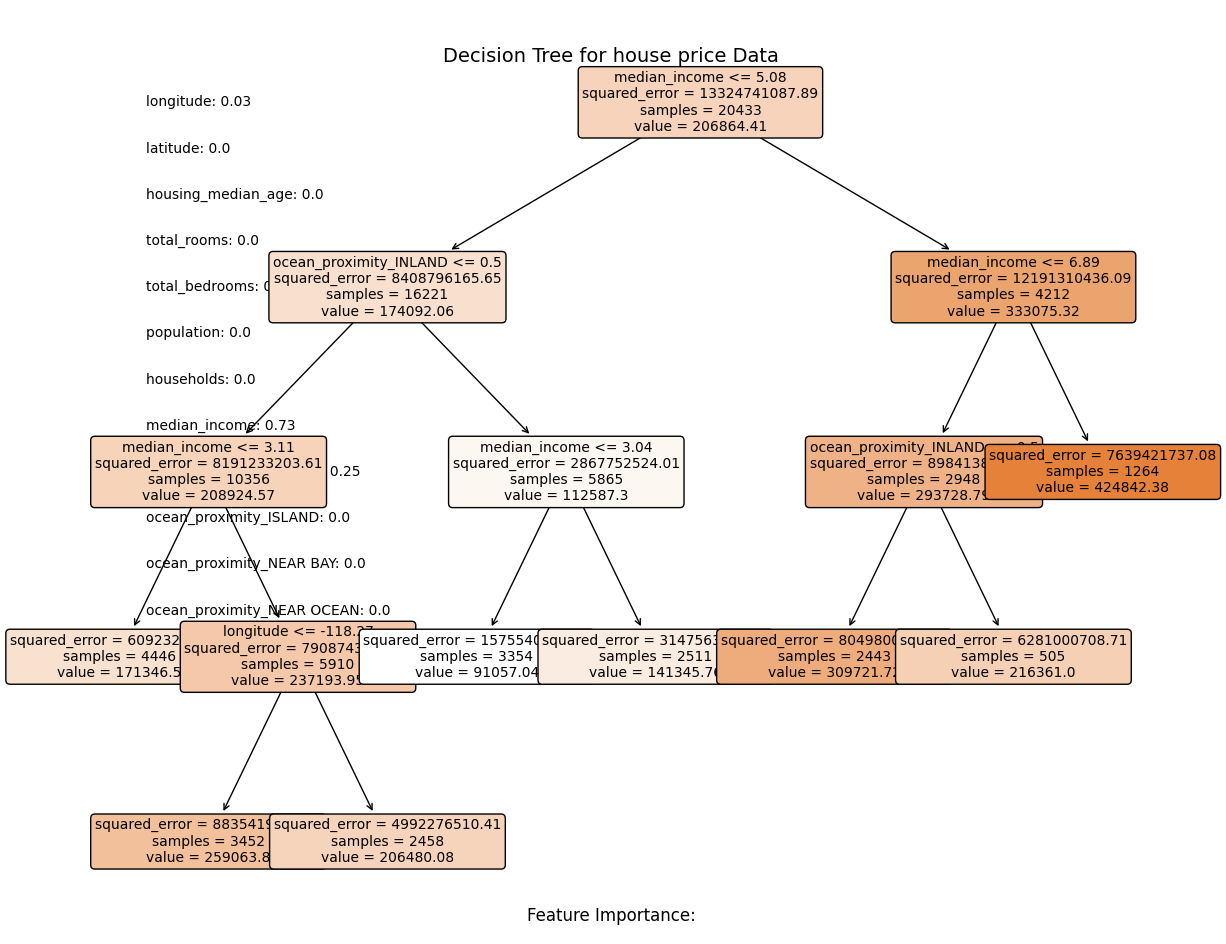

In [12]:
# Plot the decision tree
plt.figure(figsize=(15, 12))
plot_tree(model, feature_names=X.columns, filled=True, fontsize=10, rounded=True, precision=2)

# Add text annotations
plt.text(0.5, 0.95, "Decision Tree for house price Data", ha='center', va='center', fontsize=14, transform=plt.gca().transAxes)
plt.text(0.5, 0.02, "Feature Importance:", ha='center', va='center', fontsize=12, transform=plt.gca().transAxes)
for idx, feature in enumerate(X.columns):
    importance = round(model.feature_importances_[idx], 2)
    plt.text(0.1, 0.9 - idx * 0.05, f"{feature}: {importance}", ha='left', va='center', fontsize=10, transform=plt.gca().transAxes)

plt.show()

In [13]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Initialize a vector to store the evaluation metric values
evaluation_metrics = []

# Set the number of folds (k)
k = 5

# Create the KFold cross-validator
kf = KFold(n_splits=k, shuffle=True, random_state=seed)

# Loop over the folds
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Predict the target variable on the test data
    predictions = model.predict(X_test)

    # Calculate the Mean Squared Error (MSE) as the evaluation metric
    mse = mean_squared_error(y_test, predictions)

    # Append the evaluation metric to the list
    evaluation_metrics.append(mse)

# Compute the average evaluation metric across all folds
average_mse = sum(evaluation_metrics) / k
print("Average Mean Squared Error (MSE) across", k, "folds:", average_mse)

Average Mean Squared Error (MSE) across 5 folds: 5727708125.904791


Best pruned tree size: 8


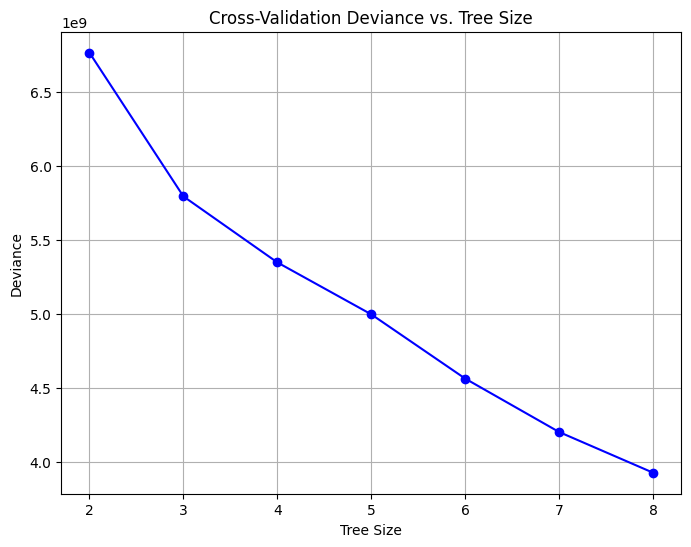

In [14]:
#Pruning
from sklearn.model_selection import KFold

# Define the range of tree sizes (pruning levels) to test
tree_sizes = range(2, 9)  # For example, test sizes from 2 to 20

# Perform cross-validation using K-Fold with K=10
kf = KFold(n_splits=10, shuffle=True, random_state=seed)

# Store the mean squared errors for different tree sizes
mse_scores = []
tree_sizes_cv = []
deviance_cv = []

# Iterate through different tree sizes and perform cross-validation
for size in tree_sizes:
    mse_score = []
    deviance_scores = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = DecisionTreeRegressor(random_state=seed, max_depth=size)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_score.append(mse)
        deviance = np.mean((y_test - y_pred) ** 2)
        deviance_scores.append(deviance)

    # Calculate the mean of the MSE scores for the current tree size
    mse_mean = np.mean(mse_score)
    mse_scores.append(mse_mean)

    # Calculate the average deviance for the current tree size
    mean_deviance = np.mean(deviance_scores)

    # Store tree size and mean deviance
    tree_sizes_cv.append(size)
    deviance_cv.append(mean_deviance)

# Find the index of the best-pruned tree (lowest MSE score)
best_pruned_idx = np.argmin(mse_scores)
best_pruned_size = tree_sizes[best_pruned_idx]

print("Best pruned tree size:", best_pruned_size)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(tree_sizes_cv, deviance_cv, marker='o', linestyle='-', color='b')
plt.xlabel('Tree Size')
plt.ylabel('Deviance')
plt.title('Cross-Validation Deviance vs. Tree Size')
plt.grid(True)
plt.show()

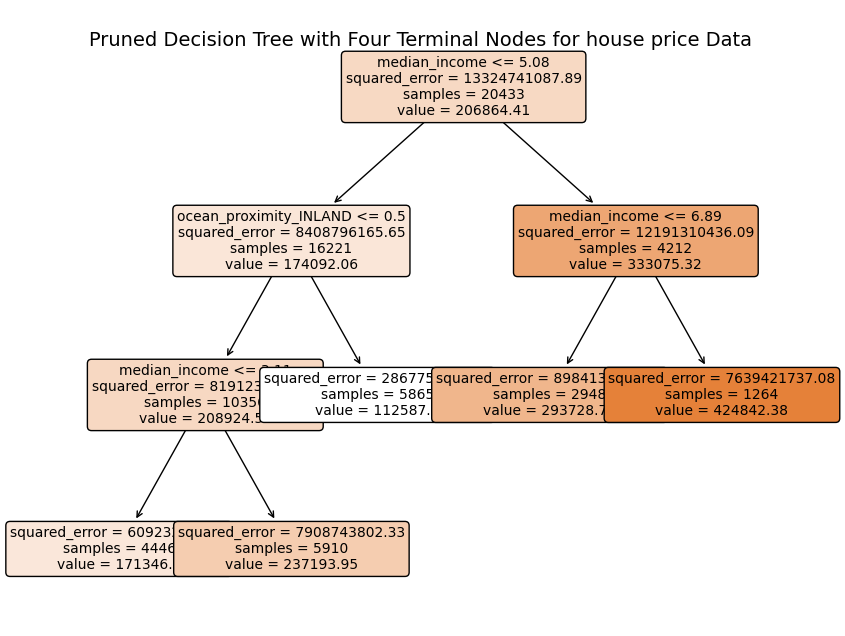

In [18]:
pruned_model = DecisionTreeRegressor(random_state=seed, max_leaf_nodes=5)
pruned_model.fit(X, y)

# Plot the pruned decision tree
plt.figure(figsize=(10, 8))
plot_tree(pruned_model, feature_names=X.columns, filled=True, fontsize=10, rounded=True, precision=2)

# Add text annotations
plt.text(0.5, 0.95, "Pruned Decision Tree with Four Terminal Nodes for house price Data", ha='center', va='center', fontsize=14, transform=plt.gca().transAxes)

plt.show()


In [21]:
from sklearn.metrics import mean_squared_error
model = DecisionTreeRegressor(max_leaf_nodes=5, random_state=seed)

# Initialize a vector to store the evaluation metric values
evaluation_metrics = []

# Set the number of folds (k)
k = 5

# Create the KFold cross-validator
kf = KFold(n_splits=k, shuffle=True, random_state=seed)

# Loop over the folds
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Predict the target variable on the test data
    predictions = model.predict(X_test)

    # Calculate the Mean Squared Error (MSE) as the evaluation metric
    mse = mean_squared_error(y_test, predictions)

    # Append the evaluation metric to the list
    evaluation_metrics.append(mse)

# Compute the average evaluation metric across all folds
average_mse = sum(evaluation_metrics) / k
print("Average Mean Squared Error (MSE) across", k, "folds:", average_mse)


Average Mean Squared Error (MSE) across 5 folds: 6256784405.687315


In [22]:
#Random forest

from sklearn.ensemble import RandomForestRegressor
seed = 1

# Create a random forest model  and ntree=1000
model = RandomForestRegressor(n_estimators=1000, random_state=seed)
# Fit the model to the data
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame to display the feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

display(importance_df)

,Feature,Importance
7,median_income,0.482574
8,ocean_proximity_INLAND,0.143317
0,longitude,0.110909
1,latitude,0.106373
2,housing_median_age,0.051599
5,population,0.030673
3,total_rooms,0.024004
4,total_bedrooms,0.021358
6,households,0.018305
11,ocean_proximity_NEAR OCEAN,0.009468


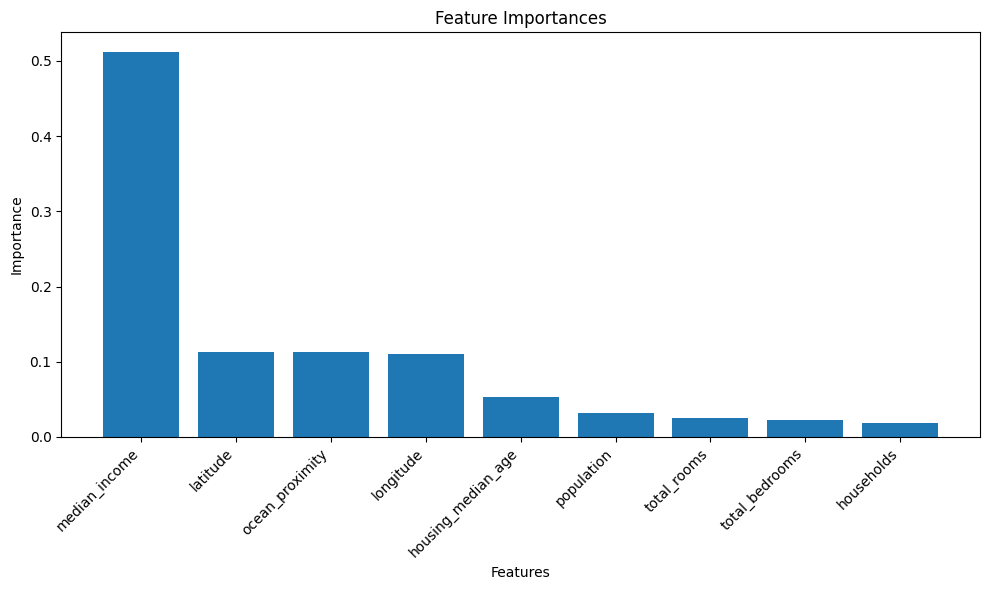

In [14]:
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

In [23]:
# Initialize a vector to store the evaluation metric values
evaluation_metrics = []

# Set the number of folds (k)
k = 5

# Create the KFold cross-validator
kf = KFold(n_splits=k, shuffle=True, random_state=seed)

# Loop over the folds
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Predict the target variable on the test data
    predictions = model.predict(X_test)

    # Calculate the Mean Squared Error (MSE) as the evaluation metric
    mse = mean_squared_error(y_test, predictions)

    # Append the evaluation metric to the list
    evaluation_metrics.append(mse)

# Compute the average evaluation metric across all folds
average_mse = sum(evaluation_metrics) / k
print("Average Mean Squared Error (MSE) across", k, "folds:", average_mse)

Average Mean Squared Error (MSE) across 5 folds: 2342104821.2370577


In [16]:
from sklearn.ensemble import RandomForestRegressor
num_features_per_split = round(X.shape[1] / 3)

# Create a random forest modelntree=1000
model = RandomForestRegressor(n_estimators=1000, max_features=num_features_per_split, random_state=seed)
# Fit the model to the data
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame to display the feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

display(importance_df)

,Feature,Importance
7,median_income,0.410892
0,longitude,0.143860
1,latitude,0.133670
8,ocean_proximity,0.099939
2,housing_median_age,0.050834
5,population,0.049714
3,total_rooms,0.043649
4,total_bedrooms,0.034645
6,households,0.032797


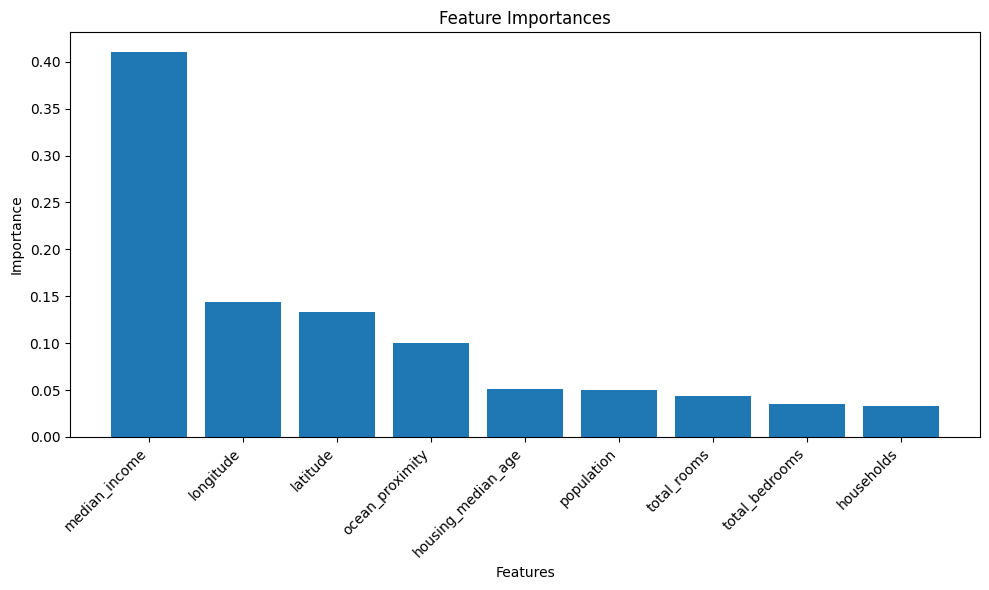

In [17]:
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

In [18]:
# Initialize a vector to store the evaluation metric values
evaluation_metrics = []

# Set the number of folds (k)
k = 5

# Create the KFold cross-validator
kf = KFold(n_splits=k, shuffle=True, random_state=seed)

# Loop over the folds
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Predict the target variable on the test data
    predictions = model.predict(X_test)

    # Calculate the Mean Squared Error (MSE) as the evaluation metric
    mse = mean_squared_error(y_test, predictions)

    # Append the evaluation metric to the list
    evaluation_metrics.append(mse)

# Compute the average evaluation metric across all folds
average_mse = sum(evaluation_metrics) / k
print("Average Mean Squared Error (MSE) across", k, "folds:", average_mse)

Average Mean Squared Error (MSE) across 5 folds: 2340406764.4105678


In [20]:
from sklearn.ensemble import GradientBoostingRegressor
# Create the Gradient Boosting Regressor
model = GradientBoostingRegressor(n_estimators=1000, max_depth=1, learning_rate=0.01, random_state=seed)

# Fit the model to the data
model.fit(X, y)
# Access the feature importances
feature_importances = model.feature_importances_

# Print the feature importances
print("Feature Importances:")
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance}")

# Access the training score (R-squared)
train_score = model.score(X, y)

print(f"\nTraining R-squared: {train_score}")

Feature Importances:
longitude: 0.03005516603220401
latitude: 0.03207058307198306
housing_median_age: 0.019870438985165478
total_rooms: 0.0
total_bedrooms: 0.0036739188069693494
population: 0.0
households: 0.0
median_income: 0.7513880687987721
ocean_proximity: 0.16294182430490609

Training R-squared: 0.6157125129461742


In [21]:
# Initialize a vector to store the evaluation metric values
evaluation_metrics = []

# Set the number of folds (k)
k = 5

# Create the KFold cross-validator
kf = KFold(n_splits=k, shuffle=True, random_state=seed)

# Loop over the folds
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Predict the target variable on the test data
    predictions = model.predict(X_test)

    # Calculate the Mean Squared Error (MSE) as the evaluation metric
    mse = mean_squared_error(y_test, predictions)

    # Append the evaluation metric to the list
    evaluation_metrics.append(mse)

# Compute the average evaluation metric across all folds
average_mse = sum(evaluation_metrics) / k
print("Average Mean Squared Error (MSE) across", k, "folds:", average_mse)

Average Mean Squared Error (MSE) across 5 folds: 5175804465.558263


In [22]:
# Sample data for the table
test_MSE = {
    'Method': ["un-pruned tree" , "pruned tree" , " bagging" ,"random-forest" ,"boosting"],
    'Test MSE': [4628838211.61,7185742218.34, 2405053597.56, 2340406764.41, 5175804465.56],
}

# Create a DataFrame from the data dictionary
df_MSE = pd.DataFrame(test_MSE)

# Display the DataFrame (table)
display(df_MSE)

,Method,Test MSE
0,un-pruned tree,4.628838e+09
1,pruned tree,7.185742e+09
2,bagging,2.405054e+09
3,random-forest,2.340407e+09
4,boosting,5.175804e+09
